In [1]:
import numpy as np
import pandas as pd
import itertools
import networkx

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
"""
SOURCE AND CREDIT
https://stackoverflow.com/questions/6284396/permutations-with-unique-values
"""
class unique_element:
    def __init__(self,value,occurrences):
        self.value = value
        self.occurrences = occurrences

def perm_unique(elements):
    eset=set(elements)
    listunique = [unique_element(i,elements.count(i)) for i in eset]
    u=len(elements)
    return perm_unique_helper(listunique,[0]*u,u-1)

def perm_unique_helper(listunique,result_list,d):
    if d < 0:
        yield tuple(result_list)
    else:
        for i in listunique:
            if i.occurrences > 0:
                result_list[d]=i.value
                i.occurrences-=1
                for g in  perm_unique_helper(listunique,result_list,d-1):
                    yield g
                i.occurrences+=1



In [4]:
def matrix2graph(M):
    DG = networkx.DiGraph()
    for i, row in enumerate(M):
        DG.add_node(i)
        for j, element in enumerate(row):
            if element!=0:
                DG.add_edge(i,j, kind=element)
    return DG

In [5]:
def show_arr(arr, ax=None):
    L = 1.5/4*len(arr)
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(L, L))
    ax.set_aspect(1)
    sns.heatmap(arr, cmap="coolwarm", ax=ax, vmin=-1.5, vmax=1.5, cbar=False, linecolor="white", linewidths=1 )
    ax.set_axis_off()

In [6]:
def get_equiv_classes(n, p, m):
    assert p+m<=n**2
    assert p+m>=0
    root = tuple([1]*p + [-1]*m + [0]*(n**2-p-m))

    # to compare graphs with edge attributes
    cem = networkx.isomorphism.categorical_edge_match("kind", 0)

    # initate list of equivalence classes
    M = np.array(root).reshape(n, n)
    G = matrix2graph(M)
    EC = [[(G, M)]]

    for perm in perm_unique(root):
        if perm!=root:
            M = np.array(perm).reshape(n, n)
            G = matrix2graph(M)
            found=False
            for C in EC:
                F, _ = C[0]
                DiGM = networkx.isomorphism.DiGraphMatcher(F, G, edge_match=cem)
                if DiGM.is_isomorphic():
                    C.append([DiGM.mapping, M])
                    found=True
            if not found:
                EC.append([(G, M)])

    return EC


In [7]:
ECs = get_equiv_classes(n=3, m=1, p=2)

In [8]:
class_index = 34
arr_index = 3 # >=1
C = ECs[class_index]

representative = C[0][1]
m = C[arr_index][0]
reorder = [m[k] for k in range(len(representative))]

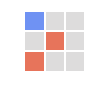

In [9]:
show_arr(representative)

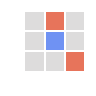

In [10]:
show_arr(C[arr_index][1])

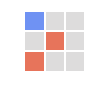

In [11]:
show_arr(C[arr_index][1][reorder].T[reorder].T)

In [12]:
def matrix2string(arr):
    return "".join([{0:"o", 1:"p", -1:"m"}[x] for x in arr.reshape(-1)])

In [13]:
def get_reorders_dict():
    """
    Generate a dictonary with matrices in keys
    (encoded as strings via matrix2strin) and
    col/row permutations in values.
    
    The col/row permutations are such that each
    matrix is mapped to the canonical representative
    of its equivalence class.
    
    """
    n=3
    classes = {}
    for p in range(0,n**2+1):
        for m in range(0,n**2-p+1):
            classes[(p, m)] = get_equiv_classes(n=n, m=m, p=p)

    arrstring2reorder = {}
    for cls in classes.values():
        for cl in cls:
            for m,arr in cl:
                if not isinstance(m, dict):
                    m = {x:x for x in range(n)}
                arrstring = matrix2string(arr)
                reorder = [m[x] for x in range(n)]
                arrstring2reorder[arrstring] = reorder
                
    return arrstring2reorder

In [14]:
reorders_dict = get_reorders_dict()

In [15]:
df = pd.read_pickle("../test.p").astype(float)

In [16]:
J = pd.DataFrame(pd.read_pickle("../J.p"))

In [22]:
def get_canonical_and_corrs_from_ids(ids, reorders_dict):
    n = 3
    arrstring = matrix2string(J.loc[ids, ids].values)
    
    reorder = reorders_dict[arrstring]
    canonical_arrstring = "".join((np.array([x for x in arrstring]).reshape(n, n)[reorder].T[reorder].T).reshape(-1))
    corrs = df[ids[reorder]].corr()
    
    return canonical_arrstring, corrs, len(df[ids[reorder]].drop_duplicates())

In [25]:
test = {}
phis = {}
for ids in itertools.combinations(range(len(J)),3):
    ids = np.array(ids)
    canonical_arrstring, corrs, phi = get_canonical_and_corrs_from_ids(ids, 
                                                                  reorders_dict)
    x, y, z = corrs.values[0, 1], corrs.values[0, 2], corrs.values[1, 2]
    if canonical_arrstring not in test.keys():
        test[canonical_arrstring] = [[x, y, z]]
        phis[canonical_arrstring] = [phi]
    else:
        test[canonical_arrstring].append([x, y, z])
        phis[canonical_arrstring].append(phi)

In [59]:
m = np.concatenate(list(phis.values())).mean()
x, y = np.array([[[k.count("o")]*len(v),v] for k,v in phis.items() if k.count("o")<90]).T

In [60]:
x = np.concatenate(x)
y = np.concatenate(y)

Text(0,0.5,'Number of different steady states')

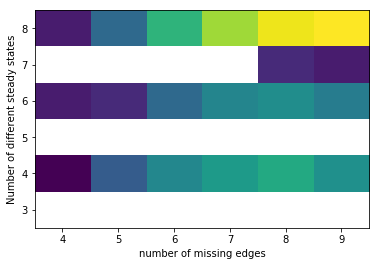

In [61]:
plt.hist2d(x, y, bins=(np.linspace(3.5, 9.5, num=7), np.linspace(2.5, 8.5, num=7)), norm=LogNorm());
plt.xlabel("number of missing edges")
plt.ylabel("Number of different steady states")

In [51]:
from matplotlib.colors import LogNorm